In [2]:
import os

from skimage import io, transform

import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils

import math
import matplotlib.pyplot as plt

import random


In [3]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using {device}")

Using cuda


In [4]:
IMAGE_SIZE = 80 #Actual frames = 1440. must be divisible by 4
IMAGE_CHANNELS = 3
LATENT_VECTOR_SIZE = 100

Set the random seed:

In [5]:
torch.manual_seed(1337)

In [6]:
def show_examples(model, title=None, big=False):
    latent_space_samples = torch.randn((batch_size, LATENT_VECTOR_SIZE))
    generated_samples = model(latent_space_samples)

    generated_samples = generated_samples.detach()
    fig = plt.figure()
    if title:
        fig.text(0.5, 1.0 if big else 0.7, title, ha='center', va='center')
    for plot_idx, dataset_idx  in enumerate(torch.randint(len(generated_samples), (12 if big else 4,))):
        sub = plt.subplot(3 if big else 1, 4, plot_idx+1)
        plt.tight_layout()
        sub.axis('off')
        image = generated_samples[dataset_idx.item()].permute(1,2,0)
        plt.imshow(image *0.5 + 0.5)
    fig.show()

# Preparing training data

In [7]:
class VetleDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, sample_count, image_dir, transform=None):
        """
        Arguments:
            sample_count (int): How many samples
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.sample_count = sample_count
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return self.sample_count

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        frameno = str(idx+1).zfill(4)
        filename = "frame" + frameno + ".png"

        img_name = os.path.join(self.image_dir,
                                filename)
        image = torchvision.io.read_image(img_name).float()
        

        if self.transform:
            image = self.transform(image)

        # Return image with a label. We won't use it, but it seems like tensorflow expects it
        return [image,0]

In [8]:
transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.Normalize(128,128)])

In [9]:
dataset = VetleDataset(2905, "assets/frames/", transform=transform)

In [ ]:
dataset = torchvision.datasets.Flowers102()

Plot training data:

C:\Users\vmang\AppData\Local\Temp\ipykernel_11368\14490758.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


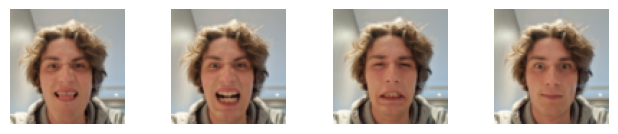

In [10]:
fig = plt.figure()
for plot_idx, dataset_idx  in enumerate(torch.randint(len(dataset), (4,))):
    sub = plt.subplot(1, 4, plot_idx+1)
    plt.tight_layout()
    sub.axis('off')
    image = dataset[dataset_idx.item()][0].permute(1,2,0)
    plt.imshow(image * 0.5 + 0.5)
fig.show()

Create data loader:

In [11]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)


# The models


## Discriminator

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
             nn.Conv2d(
                in_channels=IMAGE_CHANNELS,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d([2, 2], stride=2),
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d([2, 2], stride=2),
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d([2, 2], stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * (IMAGE_SIZE // 8)**2, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), 128 * (IMAGE_SIZE // 8)**2)
        output = self.classifier(features)
        return output

In [13]:
discriminator = Discriminator()

## Generator

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcnn = nn.Sequential(
            nn.Linear(in_features=LATENT_VECTOR_SIZE, out_features=128*(IMAGE_SIZE//4)**2)
        )
        
        self.conv = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2), 
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout2d(p=0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        post_fcnn = self.fcnn(x)
        pre_cnn = post_fcnn.view(post_fcnn.size(0), 128, IMAGE_SIZE//4, IMAGE_SIZE//4)
        output = self.conv(pre_cnn)
        return output



C:\Users\vmang\AppData\Local\Temp\ipykernel_11368\3816338196.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


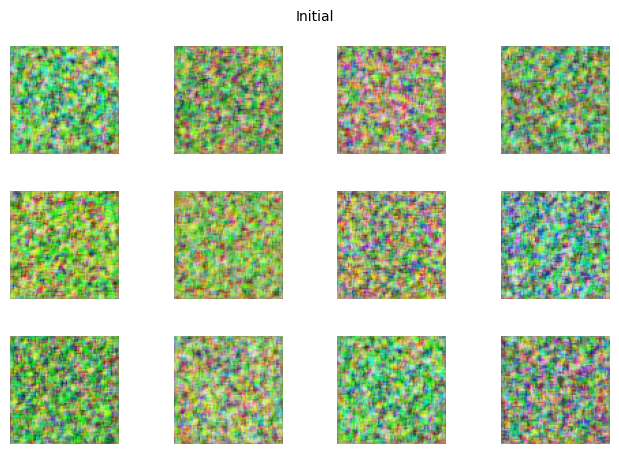

In [15]:
generator = Generator()
show_examples(generator, title="Initial", big=True)

# Training


## Hyperparameters

In [16]:
lr = 0.0002
num_epochs = 30
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Loop

0 
Epoch: 0 Loss D.: 0.013195055536925793
Epoch: 0 Loss G.: 3.2310948371887207


C:\Users\vmang\AppData\Local\Temp\ipykernel_11368\3816338196.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


1 2 3 4 5 6 7 8 9 10 
Epoch: 10 Loss D.: 5.6951485021272674e-05
Epoch: 10 Loss G.: 0.7643654346466064
11 12 13 14 15 16 17 18 19 20 
Epoch: 20 Loss D.: 2.1017753169871867e-05
Epoch: 20 Loss G.: 0.4102955162525177
21 22 23 24 25 26 27 28 29 

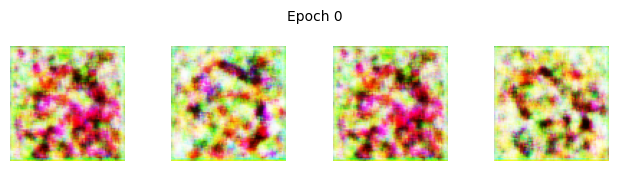

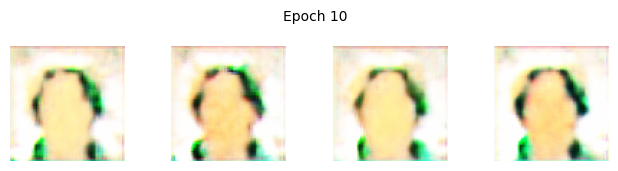

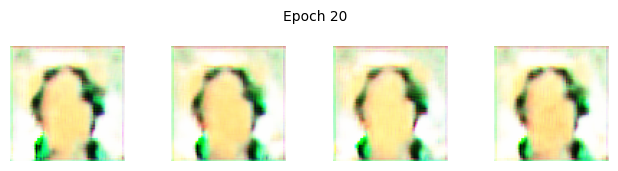

In [17]:
timeline = {
    "loss_discriminator":[],
    "loss_generator":[],
}
for epoch in range(num_epochs):
    print(epoch, end=" ")
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((real_samples.shape[0], 1))
        latent_space_samples = torch.randn((batch_size, LATENT_VECTOR_SIZE))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, LATENT_VECTOR_SIZE))
        real_labels = torch.ones((batch_size, 1))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == len(train_loader) - 1:
            timeline["loss_discriminator"].append(loss_discriminator.detach())
            timeline["loss_generator"].append(loss_generator.detach())
            if epoch % 10 == 0:
                print("")
                print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
                print(f"Epoch: {epoch} Loss G.: {loss_generator}")
                show_examples(generator, title=f"Epoch {epoch}")
           

# Results

C:\Users\vmang\AppData\Local\Temp\ipykernel_11368\3816338196.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


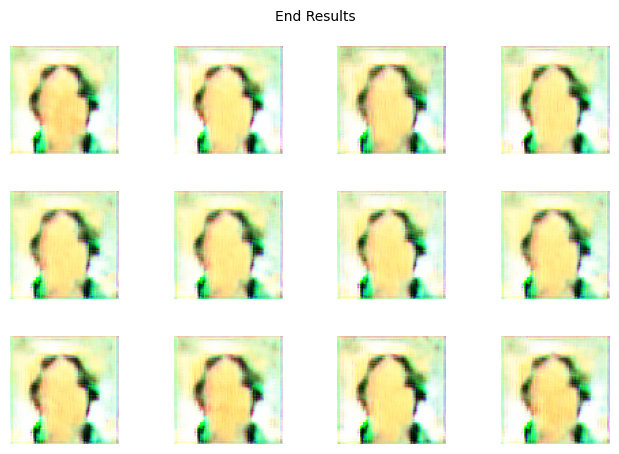

In [18]:
show_examples(generator, title="End Results", big=True)


## Stats

C:\Users\vmang\AppData\Local\Temp\ipykernel_11368\3322973481.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  discriminator_plot.show()
C:\Users\vmang\AppData\Local\Temp\ipykernel_11368\3322973481.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  generator_plot.show()


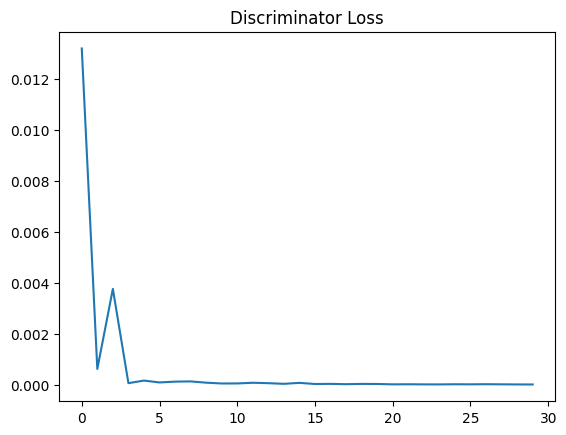

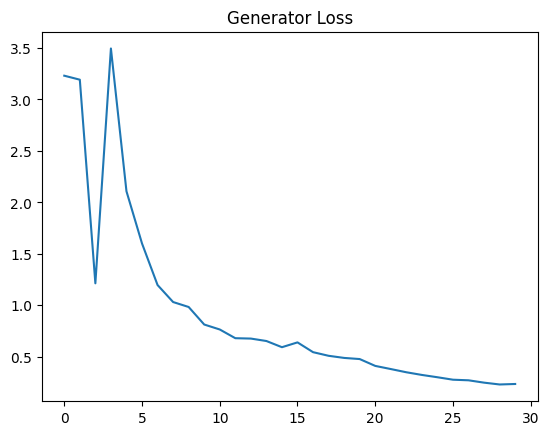

In [19]:
discriminator_plot = plt.figure()
plt.plot(range(0, num_epochs), timeline["loss_discriminator"])
plt.title("Discriminator Loss")
discriminator_plot.show()
generator_plot = plt.figure()
plt.plot(range(0, num_epochs), timeline["loss_generator"])
plt.title("Generator Loss")
generator_plot.show()

# Save model

In [20]:
SAVE = False
NAME = "GANgrud02"
path = f"saved/{NAME}.gangrud"
if SAVE:
    torch.save(generator.state_dict(), path)

## View saved model

In [21]:
saved_model = Generator()
saved_model.load_state_dict(torch.load(path))

RuntimeError: Error(s) in loading state_dict for Generator:
	Missing key(s) in state_dict: "conv.8.weight", "conv.8.bias", "conv.8.running_mean", "conv.8.running_var", "conv.10.weight", "conv.10.bias", "conv.11.weight", "conv.11.bias", "conv.11.running_mean", "conv.11.running_var", "conv.14.weight", "conv.14.bias". 
	Unexpected key(s) in state_dict: "conv.6.weight", "conv.6.bias", "conv.7.running_mean", "conv.7.running_var", "conv.7.num_batches_tracked", "conv.9.weight", "conv.9.bias". 
	size mismatch for conv.7.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([64, 128, 3, 3]).

C:\Users\vmang\AppData\Local\Temp\ipykernel_18152\3816338196.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


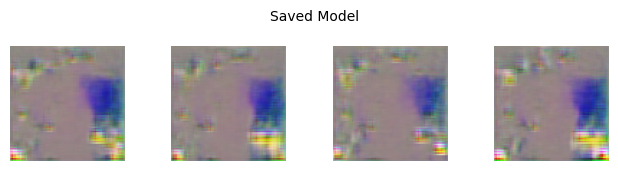

In [ ]:
show_examples(saved_model, title="Saved Model")